In [ ]:
!pip install tensorflow==1.14.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [ ]:
import pandas as pd
import numpy as np
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Hotel_Reviews.csv.zip

Archive:  /content/drive/MyDrive/Hotel_Reviews.csv.zip
replace Hotel_Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Hotel_Reviews.csv       


In [ ]:
# Importing dataset
reviews_df = pd.read_csv('/content/Hotel_Reviews.csv')
print(reviews_df.dtypes)

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object


In [ ]:
def clean(text):
    '''
    '''
    text = text.lower()
    text = text.replace("ain't", "am not")
    text = text.replace("aren't", "are not")
    text = text.replace("can't", "cannot")
    text = text.replace("can't've", "cannot have")
    text = text.replace("'cause", "because")
    text = text.replace("could've", "could have")
    text = text.replace("couldn't", "could not")
    text = text.replace("couldn't've", "could not have")
    text = text.replace("should've", "should have")
    text = text.replace("should't", "should not")
    text = text.replace("should't've", "should not have")
    text = text.replace("would've", "would have")
    text = text.replace("would't", "would not")
    text = text.replace("would't've", "would not have")
    text = text.replace("didn't", "did not")
    text = text.replace("doesn't", "does not")
    text = text.replace("don't", "do not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hadn't've", "had not have")
    text = text.replace("hasn't", "has not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd", "he would")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd've", "he would have")
    text = text.replace("'s", "")
    text = text.replace("'t", "")
    text = text.replace("'ve", "")
    text = text.replace(".", " . ")
    text = text.replace("!", " ! ")
    text = text.replace("?", " ? ")
    text = text.replace(";", " ; ")
    text = text.replace(":", " : ")
    text = text.replace(",", " , ")
    text = text.replace("´", "")
    text = text.replace("‘", "")
    text = text.replace("’", "")
    text = text.replace("“", "")
    text = text.replace("”", "")
    text = text.replace("\'", "")
    text = text.replace("\"", "")
    text = text.replace("-", "")
    text = text.replace("–", "")
    text = text.replace("—", "")
    text = text.replace("[", "")
    text = text.replace("]","")
    text = text.replace("{","")
    text = text.replace("}", "")
    text = text.replace("/", "")
    text = text.replace("|", "")
    text = text.replace("(", "")
    text = text.replace(")", "")
    text = text.replace("$", "")
    text = text.replace("+", "")
    text = text.replace("*", "")
    text = text.replace("%", "")
    text = text.replace("#", "")
    text = text.replace("\n", " \n ")
    text = text.replace("\n", "")
    text = text.replace("_", " _ ")
    text = text.replace("_", "")
    text = ''.join([i for i in text if not i.isdigit()])

    return text

positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values

cleaned_positive_reviews = [clean(r) for r in positive_reviews] 
cleaned_negative_reviews = [clean(r) for r in negative_reviews] 

reviews_df['Positive_Review'] = cleaned_positive_reviews
reviews_df['Negative_Review'] = cleaned_negative_reviews

In [ ]:
# Shuffling data
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)

# Extracting all text
positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values
reviews_text = []

for p,n in zip(positive_reviews, negative_reviews) : 
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        reviews_text.append(n)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        reviews_text.append(p)
    else : 
        reviews_text.append(n)
        reviews_text.append(p)

# Preprocessing training data
training_df = reviews_df.loc[:1000]
positive_reviews_filtered = training_df['Positive_Review'].values
negative_reviews_filtered = training_df['Negative_Review'].values
training_reviews = []
labels = []

for idx,(p,n) in enumerate(zip(positive_reviews_filtered, negative_reviews_filtered)) : 
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] : 
        training_reviews.append(n)
        labels.append(0)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(p)
        labels.append(1)
    else :
        training_reviews.append(n)
        labels.append(0)
        training_reviews.append(p)
        labels.append(1)

# Creating datasets
dict1 ={
    'reviews' : training_reviews,
    'labels' : labels
}
sentiment_df = pd.DataFrame.from_dict(dict1)


dict2 ={
    'reviews_text' : reviews_text
}
reviews_text_df = pd.DataFrame.from_dict(dict2)

In [ ]:
text_reviews = [str(r) for r in reviews_text_df['reviews_text'].values]

sentences = []

for review in text_reviews:
    words = text_to_word_sequence(review)
    sentences.append(words)

embeddings_model = Word2Vec(sentences, min_count=1, sg=1, size=128)
words = list(embeddings_model.wv.vocab)
print('{} WORDS '.format(len(words)))
print('Printing first 100:')
print(words[:100])

76904 WORDS 
Printing first 100:
['nothing', 'very', 'nice', 'hotel', 'best', 'location', 'friendly', 'and', 'helpful', 'staff', 'air', 'conditioning', 'would', 'have', 'been', 'a', 'welcome', 'addition', 'only', 'plugs', 'in', 'the', 'room', 'not', 'nearly', 'enough', 'with', 'selection', 'of', 'phones', 'ipads', 'cameras', 'to', 'charge', 'efficient', 'fridge', 'was', 'great', 'for', 'cold', 'drinks', 'as', 'weather', 'hot', 'sticky', 'garden', 'quiet', 'but', 'central', 'plenty', 'shops', 'restaurants', 'close', 'by', 'shampoos', 'etc', 'provided', 'were', 'good', 'quality', 'excellent', 'breakfast', 'luggage', 'storage', 'facility', 'after', 'check', 'out', 'useful', 'small', 'bathroom', 'extremely', 'comfortable', 'bed', 'two', 'beds', 'together', 'is', 'same', 'than', 'king', 'it', 'should', 'be', 'must', 'when', 'you', 'pay', 'per', 'nite', 'lobby', 'smell', 'smoke', 'allowed', 'bar', 'didnt', 'replace', 'amenitties', 'shower', 'they']


In [ ]:
# Querying SQLlite database to extract needed words embeddings
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text_reviews)
vocabSize = len(tokenizer.word_index) + 1

In [ ]:
# Recreating embeddings index based on Tokenizer vocabulary
word2vec_vocabulary = embeddings_model.wv.vocab
embeddingIndex = dict()
counter = 0
for word, i in tokenizer.word_index.items():
    if word in word2vec_vocabulary :
        embeddingIndex[word] = embeddings_model[word]
    else:
        counter += 1

print("{} words without pre-trained embedding!".format(counter))
    
# Prepare embeddings matrix
embeddingMatrix = zeros((vocabSize, 128))
for word, i in tokenizer.word_index.items():
    embeddingVector = embeddingIndex.get(word)
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


0 words without pre-trained embedding!


In [ ]:
reviews = [ str(r) for r in sentiment_df['reviews'].values]
labels = sentiment_df['labels'].values

oneHotReviews = tokenizer.texts_to_sequences(reviews)
encodedReviews = keras.preprocessing.sequence.pad_sequences(oneHotReviews, maxlen=40, padding='post')

X_train, X_test, y_train, y_test = train_test_split(encodedReviews, labels, test_size=0.33, random_state=42)

In [ ]:
# define neural network
CNN = keras.models.Sequential()
CNN.add(keras.layers.Embedding(vocabSize, 128,weights=[embeddingMatrix], input_length=40, trainable=True))
CNN.add(Conv1D(128, 2, activation='relu'))
CNN.add(GlobalMaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(1, activation='sigmoid'))
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
CNN.fit(X_train, y_train, epochs=5, verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
1144/1144 [==============================] - 7s 6ms/sample - loss: 0.4808 - acc: 0.7867
Epoch 2/5
1144/1144 [==============================] - 6s 5ms/sample - loss: 0.2521 - acc: 0.9100
Epoch 3/5
1144/1144 [==============================] - 6s 5ms/sample - loss: 0.1848 - acc: 0.9327
Epoch 4/5
1144/1144 [==============================] - 7s 6ms/sample - loss: 0.1449 - acc: 0.9545
Epoch 5/5
1144/1144 [==============================] - 7s 6ms/sample - loss: 0.1136 - acc: 0.9685


In [ ]:
loss, accuracy = CNN.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

564/564 [==============================] - 0s 319us/sample - loss: 0.2763 - acc: 0.9007
Test Loss: 0.27629820865096777
Test Accuracy: 0.9007092118263245


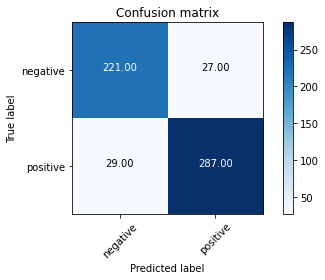

In [ ]:
predictions = CNN.predict_classes(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
title = 'Confusion matrix'
cmap = plt.cm.Blues
classes=["negative","positive"]
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(y_test, predictions, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       248
           1       0.91      0.91      0.91       316

    accuracy                           0.90       564
   macro avg       0.90      0.90      0.90       564
weighted avg       0.90      0.90      0.90       564



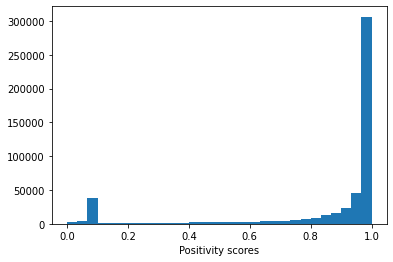

In [ ]:
positive_reviews = [str(r) for r in reviews_df['Positive_Review'].values]

for idx, review in enumerate(positive_reviews):
    words = text_to_word_sequence(review)     
    if(len(words) > 40): 
        words = words[:40]
        positive_reviews[idx] = ' '.join(words)

oneHotPositiveReviews = tokenizer.texts_to_sequences(positive_reviews)
encodedPositiveReviews = keras.preprocessing.sequence.pad_sequences(oneHotPositiveReviews, maxlen=40, padding='post')


positivity_predictions = CNN.predict_proba(encodedPositiveReviews)

plt.hist(positivity_predictions, bins=30)
plt.xlabel('Positivity scores');
plt.show() 

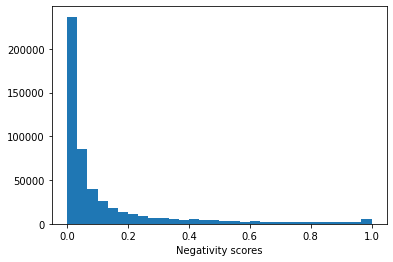

In [ ]:
negative_reviews = [str(r) for r in reviews_df['Negative_Review'].values]

for idx, review in enumerate(negative_reviews):
    words = text_to_word_sequence(review)      
    if(len(words) > 40): 
        words = words[:40]
        negative_reviews[idx] = ' '.join(words)

oneHotNegativeReviews = tokenizer.texts_to_sequences(negative_reviews)
encodedNegativeReviews = keras.preprocessing.sequence.pad_sequences(oneHotNegativeReviews, maxlen=40, padding='post')


negativity_predictions = CNN.predict_proba(encodedNegativeReviews)
    
# print(negativity_predictions)
plt.hist(negativity_predictions, bins=30)
plt.xlabel('Negativity scores');
plt.show() 

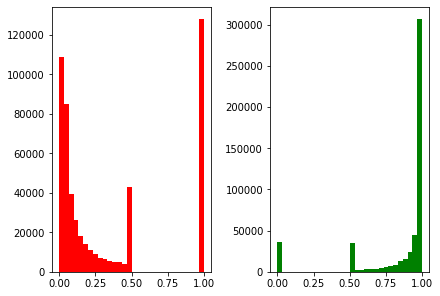

In [ ]:
negative_reviews = reviews_df['Negative_Review'].values
positive_reviews = reviews_df['Positive_Review'].values

missing = ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative']

for idx, (text,score) in enumerate(zip(positive_reviews, positivity_predictions)):
    if text in missing : positivity_predictions[idx] = 0.0
    elif score < 0.5 : positivity_predictions[idx] = 0.501

for idx, (text,score) in enumerate(zip(negative_reviews, negativity_predictions)):
    if text in missing : negativity_predictions[idx] = 1.0
    elif score > 0.5 : negativity_predictions[idx] = 0.499

# Printing final distributions
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
axes[0].hist(negativity_predictions, color='red', bins=30)
axes[1].hist(positivity_predictions, color='green', bins=30)
plt.show() 

In [ ]:
reviews_df['Negative_Review_Score'] = negativity_predictions
reviews_df['Positive_Review_Score'] = positivity_predictions
reviews_df['Sentiment_Review_Score'] = (positivity_predictions+negativity_predictions)/2

positive_reviews = reviews_df['Positive_Review']
negative_reviews = reviews_df['Negative_Review']
sentiment_scores = reviews_df['Sentiment_Review_Score']
reviewer_score = reviews_df['Reviewer_Score']

print('Positive review: {}'.format(reviews_df['Positive_Review'][100]))
print('Negative review: {}'.format(reviews_df['Negative_Review'][100]))
print('Sentiment score: {}'.format(reviews_df['Sentiment_Review_Score'][100]))
print('Reviewer score: {}'.format(reviews_df['Reviewer_Score'][100]))

Positive review:  the location of this hotel was very good and very close to the duomo it s very clean almost all of the staff were so nice and helpful
Negative review:  it was too noisy we keep hearing high heel steps day and night one of the reciptionists was a bit mean
Sentiment score: 0.4969569444656372
Reviewer score: 7.5


In [ ]:
target = []
final_scores = reviews_df['Sentiment_Review_Score'].values

for f in final_scores : 
    if f >= 0.7 : target.append(4)
    elif f < 0.7 and f >= 0.5 : target.append(3)
    elif f < 0.5 and f >= 0.3 : target.append(2)
    else: target.append(1)

reviews_df['Sentiment_Review_Class'] = target

Number of best reviews:  161713
Number of good reviews:  220481
Number of bad reviews:   82296
Number of worst reviews: 51248


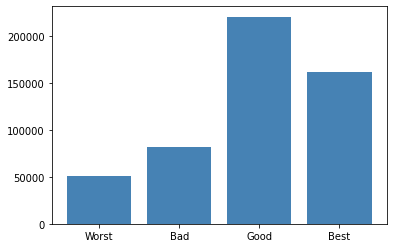

In [ ]:
reviews_best = reviews_df[reviews_df['Sentiment_Review_Class'] == 4]['Positive_Review'].values
print('Number of best reviews:  {}'.format(len(reviews_best)))
      
reviews_good = reviews_df[reviews_df['Sentiment_Review_Class'] == 3]['Positive_Review'].values
print('Number of good reviews:  {}'.format(len(reviews_good)))
      
reviews_bad = reviews_df[reviews_df['Sentiment_Review_Class'] == 2]['Negative_Review'].values
print('Number of bad reviews:   {}'.format(len(reviews_bad)))
      
reviews_worst = reviews_df[reviews_df['Sentiment_Review_Class'] == 1]['Negative_Review'].values
print('Number of worst reviews: {}'.format(len(reviews_worst)))

fig, ax = plt.subplots()
x = ['Worst','Bad', 'Good', 'Best']
y = [len(reviews_worst),len(reviews_bad),len(reviews_good),len(reviews_best)]
vert_bars = ax.bar(x, y, color='steelblue', align='center')
plt.show()

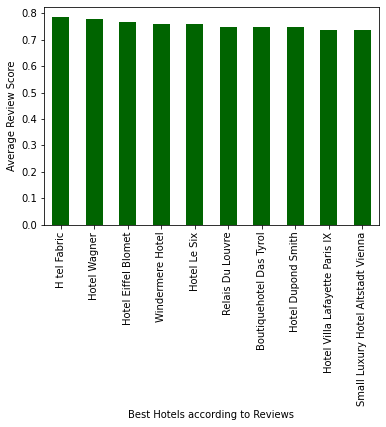

Hotel_Name
H tel Fabric                          0.784224
Hotel Wagner                          0.778782
Hotel Eiffel Blomet                   0.768251
Windermere Hotel                      0.759877
Hotel Le Six                          0.758617
Relais Du Louvre                      0.749086
Boutiquehotel Das Tyrol               0.748886
Hotel Dupond Smith                    0.748742
Hotel Villa Lafayette Paris IX        0.738531
Small Luxury Hotel Altstadt Vienna    0.736115
Name: Sentiment_Review_Score, dtype: float32

In [ ]:
worst_hotels = reviews_df.groupby('Hotel_Name')['Sentiment_Review_Score'].mean().sort_values(ascending=False).head(10)
worst_hotels.plot(kind="bar",color="DarkGreen")
_=plt.xlabel('Best Hotels according to Reviews')
_=plt.ylabel('Average Review Score')
plt.show()

reviews_df.groupby('Hotel_Name')['Sentiment_Review_Score'].mean().sort_values(ascending=False).head(10)


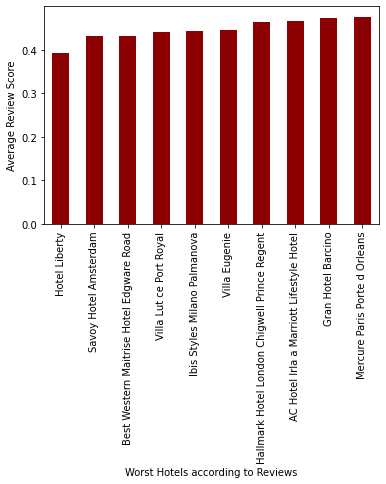

Hotel_Name
Hotel Liberty                                   0.391513
Savoy Hotel Amsterdam                           0.430992
Best Western Maitrise Hotel Edgware Road        0.431721
Villa Lut ce Port Royal                         0.439647
Ibis Styles Milano Palmanova                    0.443611
Villa Eugenie                                   0.443982
Hallmark Hotel London Chigwell Prince Regent    0.462858
AC Hotel Irla a Marriott Lifestyle Hotel        0.466471
Gran Hotel Barcino                              0.472703
Mercure Paris Porte d Orleans                   0.475848
Name: Sentiment_Review_Score, dtype: float32

In [ ]:
worst_hotels = reviews_df.groupby('Hotel_Name')['Sentiment_Review_Score'].mean().sort_values(ascending=True).head(10)
worst_hotels.plot(kind="bar",color="DarkRed")
_=plt.xlabel('Worst Hotels according to Reviews')
_=plt.ylabel('Average Review Score')
plt.show()

reviews_df.groupby('Hotel_Name')['Sentiment_Review_Score'].mean().sort_values(ascending=True).head(10)